<a href="https://colab.research.google.com/github/issatyajit/NYC-taxi-time-prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [80]:
import numpy as np
import pandas as pd

In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
df=pd.read_csv('/content/drive/MyDrive/Almabetter/NYC Taxi Data.csv')

In [83]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [84]:
df.shape

(1458644, 11)

In [85]:
df.isnull().sum(axis=0)

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [86]:
for col in df.columns:
  print(f'Number of unique values in {col} is {len(df[col].unique())}')

Number of unique values in id is 1458644
Number of unique values in vendor_id is 2
Number of unique values in pickup_datetime is 1380222
Number of unique values in dropoff_datetime is 1380377
Number of unique values in passenger_count is 10
Number of unique values in pickup_longitude is 23047
Number of unique values in pickup_latitude is 45245
Number of unique values in dropoff_longitude is 33821
Number of unique values in dropoff_latitude is 62519
Number of unique values in store_and_fwd_flag is 2
Number of unique values in trip_duration is 7417


In [87]:
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])

In [88]:
df['pickup_datetime'][0].date

<function Timestamp.date>

In [89]:
unique_years=set()
for i in df['pickup_datetime']:
  unique_years.add(i.year)

In [90]:
unique_years

{2016}

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB


In [92]:
pip install holidays

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [93]:
from datetime import date
import holidays
holiday=[]
us_holidays=holidays.USA()
for ptr in holidays.USA(years = 2016).items():
    holiday.append(ptr[0])

In [94]:
holiday

[datetime.date(2016, 1, 1),
 datetime.date(2016, 1, 18),
 datetime.date(2016, 2, 15),
 datetime.date(2016, 5, 30),
 datetime.date(2016, 7, 4),
 datetime.date(2016, 9, 5),
 datetime.date(2016, 10, 10),
 datetime.date(2016, 11, 11),
 datetime.date(2016, 11, 24),
 datetime.date(2016, 12, 25),
 datetime.date(2016, 12, 26)]

In [95]:
df['pickup_datetime'][0].date() in holiday

False

In [96]:
def get_holiday(X):
  if X in holiday:
    A=1
  else:
    A=0
  return A

In [97]:
df1=df

In [98]:
#A=np.array([])
#for i in range(df.shape[0]):
  #A=np.append(A,get_holiday(df['pickup_datetime'][i].date()))

In [99]:
df1=pd.DataFrame(A,columns=['is_holiday']).join(df)
# next we make a column date number

In [100]:
def get_date(X):
  '''returns date number'''
  return X.day
def get_month_num(X):
  return X.month
def get_week(X):
  return X.week
def get_hour(X):
  return X.hour

In [101]:
df1['date_num']=df['pickup_datetime'].apply(get_date)
df1['month_num']=df['pickup_datetime'].apply(get_month_num)
df1['week_num']=df['pickup_datetime'].apply(get_week)
df1['hour_of_day']=df['pickup_datetime'].apply(get_hour)

In [102]:
df1.head()

,is_holiday,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,date_num,month_num,week_num,hour_of_day
0,0.0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,14,3,11,17
1,0.0,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,12,6,23,0
2,0.0,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,19,1,3,11
3,0.0,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6,4,14,19
4,0.0,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,26,3,12,13


In [103]:
#Now we get the column representing distance
!pip install haversine


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [104]:
import haversine as hs
def get_distance(start_lat,start_long,end_lat,end_long):
  loc1=(start_lat,start_long)
  loc2=(end_lat,end_long)
  return hs.haversine(loc1,loc2)

In [105]:
df1['distance_in_km']=df1.apply(lambda X: get_distance(X['pickup_latitude'],X['pickup_longitude'],X['dropoff_latitude'],X['dropoff_longitude']),axis=1)

In [106]:
df1.head()

,is_holiday,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,date_num,month_num,week_num,hour_of_day,distance_in_km
0,0.0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,14,3,11,17,1.498523
1,0.0,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,12,6,23,0,1.805510
2,0.0,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,19,1,3,11,6.385107
3,0.0,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6,4,14,19,1.485500
4,0.0,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,26,3,12,13,1.188590


In [107]:
df1['average_speed_kmph']=df1['distance_in_km']*3600/df1['trip_duration']

In [108]:
df1.head()

,is_holiday,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,date_num,month_num,week_num,hour_of_day,distance_in_km,average_speed_kmph
0,0.0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,14,3,11,17,1.498523,11.856445
1,0.0,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,12,6,23,0,1.805510,9.803672
2,0.0,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,19,1,3,11,6.385107,10.822216
3,0.0,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6,4,14,19,1.485500,12.465738
4,0.0,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,26,3,12,13,1.188590,9.836608


In [109]:
len(df['id'].unique())

1458644

In [110]:
#Now we finalize the dataset
df2=df1[['vendor_id','passenger_count','is_holiday','store_and_fwd_flag','date_num',
         'month_num',	'week_num',	'hour_of_day',	'distance_in_km',	'average_speed_kmph','trip_duration']]

In [111]:
#Now we do some data exploration
num_columns= df1.select_dtypes(include=np.number).columns.tolist()

In [112]:
num_columns

['is_holiday',
 'vendor_id',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'trip_duration',
 'date_num',
 'month_num',
 'week_num',
 'hour_of_day',
 'distance_in_km',
 'average_speed_kmph']

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [114]:
df1.describe()

,is_holiday,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,date_num,month_num,week_num,hour_of_day,distance_in_km,average_speed_kmph
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.868242e-02,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02,1.550402e+01,3.516818e+00,1.383993e+01,1.360648e+01,3.440869e+00,1.442323e+01
std,1.354009e-01,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03,8.703135e+00,1.681038e+00,8.564756e+00,6.399693e+00,4.296544e+00,1.497755e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02,8.000000e+00,2.000000e+00,7.000000e+00,9.000000e+00,1.231838e+00,9.121287e+00
50%,0.000000e+00,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02,1.500000e+01,4.000000e+00,1.300000e+01,1.400000e+01,2.093720e+00,1.279200e+01
75%,0.000000e+00,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03,2.300000e+01,5.000000e+00,2.000000e+01,1.900000e+01,3.875343e+00,1.784494e+01
max,1.000000e+00,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06,3.100000e+01,6.000000e+00,5.300000e+01,2.300000e+01,1.240910e+03,9.274850e+03


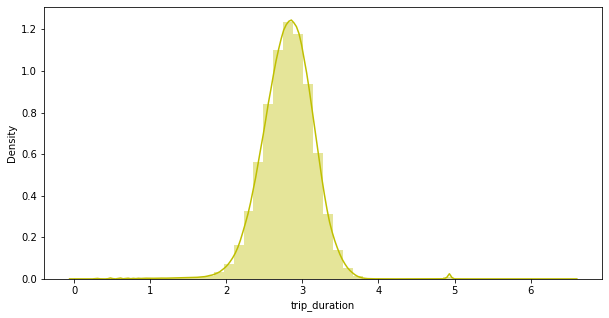

In [115]:
plt.figure(figsize=(10,5))
sns.distplot(np.log10(df1['trip_duration']),color="y")

In [116]:
!pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
import haversine as hs
def get_distance(start_lat,start_long,end_lat,end_long):
  loc1=(start_lat,start_long)
  loc2=(end_lat,end_long)
  return hs.haversine(loc1,loc2)

In [118]:
df1['distance_in_km']=df1.apply(lambda X: get_distance(X['pickup_latitude'],X['pickup_longitude'],X['dropoff_latitude'],X['dropoff_longitude']),axis=1)

In [119]:
df1.head()

,is_holiday,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,date_num,month_num,week_num,hour_of_day,distance_in_km,average_speed_kmph
0,0.0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,14,3,11,17,1.498523,11.856445
1,0.0,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,12,6,23,0,1.805510,9.803672
2,0.0,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,19,1,3,11,6.385107,10.822216
3,0.0,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6,4,14,19,1.485500,12.465738
4,0.0,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,26,3,12,13,1.188590,9.836608


In [125]:
df1[df1['average_speed_kmph']==df1['average_speed_kmph'].max()]

,is_holiday,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,date_num,month_num,week_num,hour_of_day,distance_in_km,average_speed_kmph
1176337,0.0,id3619353,2,2016-02-13 20:28:30,2016-02-13 20:28:37,1,-73.936974,40.76461,-73.789848,40.646858,N,7,13,2,6,20,18.03443,9274.849542


In [120]:
df2=df1[df1['trip_duration']>100]

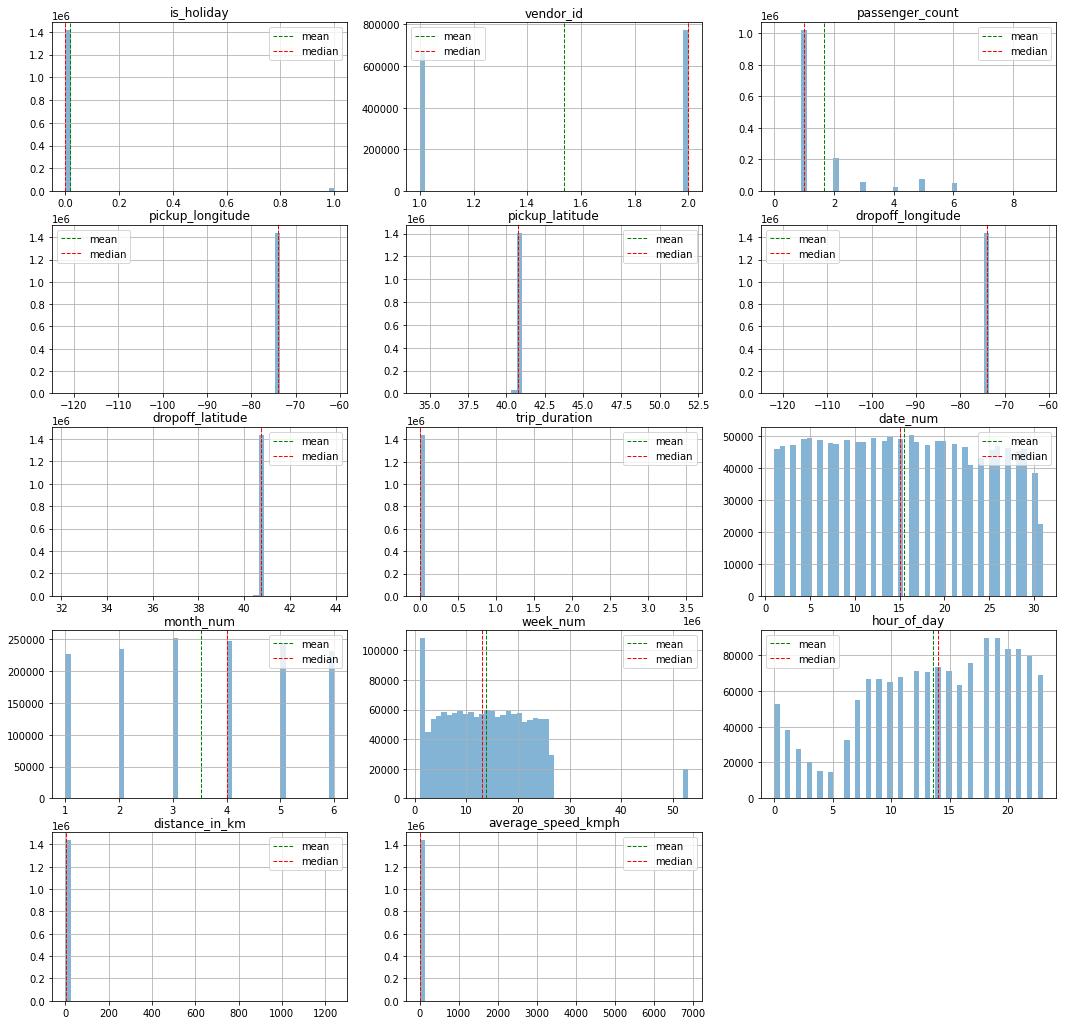

In [121]:
#plotting distribution plot for each variable
for col in num_columns:
  i=num_columns.index(col)+1
  plt.subplot(5,3,i)
  df2[col].hist(bins=50,figsize=(18,18),alpha=0.55)
  mean=df2[col].mean()
  median=df2[col].median()
  plt.axvline(mean, color='green', linestyle='dashed', linewidth=1,label='mean')
  plt.axvline(median,color='red',linestyle='dashed', linewidth=1,label='median')
  plt.legend()
  plt.title(col)

In [122]:
df2.drop(columns=['is_holiday'],inplace=True)

In [123]:
df2.drop(columns=['average_speed_kmph'],inplace=True)

In [124]:
df2.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,date_num,month_num,week_num,hour_of_day,distance_in_km
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,14,3,11,17,1.498523
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,12,6,23,0,1.805510
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,19,1,3,11,6.385107
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6,4,14,19,1.485500
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,26,3,12,13,1.188590


In [128]:
df2['store_and_fwd_flag'].value_counts()

N    1431493
Y       7862
Name: store_and_fwd_flag, dtype: int64

In [129]:
df2['passenger_count'].value_counts()

1    1018684
2     208137
5      77258
3      59328
6      47808
4      28123
0         15
9          1
8          1
Name: passenger_count, dtype: int64

In [130]:
def get_passenger(X):
  if X==1:
    A=1
  else:
    A=0
  return A

In [131]:
df2['uni_passenger']=df2['passenger_count'].apply(get_passenger)

In [133]:
df2.drop(columns=['passenger_count'],inplace=True)

In [134]:
df2.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,date_num,month_num,week_num,hour_of_day,distance_in_km,uni_passenger
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,-73.982155,40.767937,-73.964630,40.765602,N,455,14,3,11,17,1.498523,1
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,-73.980415,40.738564,-73.999481,40.731152,N,663,12,6,23,0,1.805510,1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,-73.979027,40.763939,-74.005333,40.710087,N,2124,19,1,3,11,6.385107,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,-74.010040,40.719971,-74.012268,40.706718,N,429,6,4,14,19,1.485500,1
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,-73.973053,40.793209,-73.972923,40.782520,N,435,26,3,12,13,1.188590,1


In [135]:
req_var=['vendor_id','uni_passenger','date_num',	'month_num',	'week_num',	'hour_of_day',	'distance_in_km', 'trip_duration']

In [137]:
df2=df2[req_var]

In [140]:
df2=pd.get_dummies(df2, columns=['vendor_id'],prefix=['vid'])

In [141]:
df2.head()

,uni_passenger,date_num,month_num,week_num,hour_of_day,distance_in_km,trip_duration,vid_1,vid_2
0,1,14,3,11,17,1.498523,455,0,1
1,1,12,6,23,0,1.805510,663,1,0
2,1,19,1,3,11,6.385107,2124,0,1
3,1,6,4,14,19,1.485500,429,0,1
4,1,26,3,12,13,1.188590,435,0,1


In [144]:
independent_variables=list(set(df2.columns)-{'trip_duration'})
dependent_variables=['trip_duration']

In [145]:
X=df2[independent_variables]
Y=df2[dependent_variables]